<a href="https://colab.research.google.com/github/dbarrau/TensorFlow_training/blob/main/08_introduction_to_nlp_in_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to NLP fundamentals in TensorFlow

NLP has the goal of deriving information out of the natural language (could be sequences or speech). Another common term for NLP problem is sequence to sequence problem (seq2seq)

## Architecture of an RNN

Hyperparameter / Layer type | What does it do? | Typical values
----------------------------|------------------|-----------------
Input text(s) | Targets texts/sequences we'd like to discover patterns in | Whatever you can represent as text or a sequence
Input layer | Takes in target sequence | `input_shape = [batch_size, embedding_size]` or `[batch_size, sequence_shape]`
Text vectorization layer | Maps input sequences to numbers | Multiple, can create with [`tf.keras.layers.experimental.preprocessing.TextVectorization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization)
RNN cell(s) | Finds patterns in sequences | Usually Tanh (hyperbolic tangent) ([`tf.keras.activations.tanh`](https://www.tensorflow.org/api_docs/python/tf/keras/activations/tanh))
Pooling layer | Reduces the dimensionality of learned sequence features (usually for Conv1D models) | Average ([`tf.keras.layers.GlobalAveragePooling1D`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling1D)) or Max ([`tf.keras.layers.GlobalMaxPool1D`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalMaxPool1D))
Fully connected layer | Further refines learned features from recurrent layers | [`tf.keras.layers.Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)
Output layer | Takes learned features and outputs them in shape of target labels | `output_shape = [number_of_classes]` (e.g. 2 for Disaster, Not disaster)
Output activation | Adds non-linearities to output layer | ([`tf.keras.activations.sigmoid`](https://www.tensorflow.org/api_docs/python/tf/keras/activations/sigmoid)) (binary classification) or ([`tf.keras.activations.softmax`](https://www.tensorflow.org/api_docs/python/tf/keras/activations/softmax))


# Check for GPU

In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



## Get helper functions

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-08-18 10:07:13--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-08-18 10:07:13 (66.9 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Import a series of helper functions for the notebook
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

## Get a text dataset 

The dataset we're going to be using is Kaggle's introduction to NLP dataset (text sampels of Tweets labelled as disaster or not disaster).

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

--2022-08-18 10:07:18--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.196.128, 173.194.192.128, 142.250.148.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.196.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.007s  

2022-08-18 10:07:18 (81.9 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



In [ ]:
unzip_data("nlp_getting_started.zip")

## Visualizing a text dataset

To visualize our text samples, we first have to read them in. One way to do so would be to use Python: https://realpython.com/read-write-files-python/

But we'd prefer to get visual straight away.

So another way to do this is to use Pandas.

In [ ]:
import pandas as pd

train_df = pd.read_csv("/content/train.csv")
test_df = pd.read_csv("/content/test.csv")

In [ ]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


Shuffle training dataframe (shuffling is good):


In [ ]:
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


what does the test dataframe look like?


In [ ]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


How many examples of each class are there?


In [ ]:
train_df.target.value_counts

<bound method IndexOpsMixin.value_counts of 0       1
1       1
2       1
3       1
4       1
       ..
7608    1
7609    1
7610    1
7611    1
7612    1
Name: target, Length: 7613, dtype: int64>

This dataset looks pretty well balanced, almost 50-50 per class. In case we get imbalanced datasets, we can to TensorFlow url on [classification on imbalanced data](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data)

How many total samples do we have?


In [ ]:
len(train_df), len(test_df)

(7613, 3263)

Let's visualize some random training examples

In [ ]:
import random

# Create random indexes not higher than the total dataframe
random_index = random.randint(0, len(train_df)-5)

for row in train_df_shuffled[["text", "target"]][random_index:random_index + 5].itertuples():
  _, text, target = row
  print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
  print(f"Text:\n{text}\n")
  print("---\n")

Target: 0 (not real disaster)
Text:
My man runs into burning buildings for a living but is scared to hit up a girl. I don't get it.

---

Target: 0 (not real disaster)
Text:
quick shut down the show take the stage down evacuate everyone from mthe premises Louis is upset

---

Target: 0 (not real disaster)
Text:
@PrincessDuck last week wanted the 6th sense to get blown up so far so good. James could win but he's a huge target and will be gone soon.

---

Target: 0 (not real disaster)
Text:
Do you feel like you are sinking in unhappiness? Take the quiz: http://t.co/OrJb3j803F http://t.co/MWdHXYfrag

---

Target: 1 (real disaster)
Text:
Why are you deluged with low self-image? Take the quiz: http://t.co/XsPqdOrIqj http://t.co/CQYvFR4UCy

---



# Split data into training and validation sets

In [ ]:
from sklearn.model_selection import train_test_split

# Use train_test_split to split training dataset into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.1,
                                                                            random_state=42) # Use 10% of training data for validation_split


In [ ]:
# Check the lengths
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [ ]:
# Check the first 10 samples
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object), array([0, 

## Converting text into numbers

</br>

Let's talk in terms of tokenization and embeddings. 

</br>

### Tokenization

</b>

`"I love TensorFlow"`

</br>

**How to convert this into numbers?** First we could map them into a word level tokenization.

I = 0 </br>
love = 1 </br>
TensorFlow = 2

</br>

Another way to do it is to create a one-hot encoding:

</br>


`[[1,0,0]`,
`[0,1,0]`,
`[0,0,1]]`

</br>


If we have a thousand tokens, we can already imagine how inconvenient tokenization would be in a model like this. If the length of our document is 10.000 tokens, then the length of each of these three vectors would be 10.000. In the end, it is important to abstract, that tokenization is a word-to number mapping.

</br>

### Embeddings

</br>

Look at this kind of mapping's output:

</br>


`[[0.492, 0.005, 0.019], [0.060, 0.233, 0.899], [0.741, 0.983, 9.567]]`

</br>

Every word gets turned into a vector, and we can define the size of the embedding vector. Embeddings can generate a **richer representation of relationships between tokens (can limit size and can be learned)**

## Converting text into numbers

When dealing with a text problem, one of the first things we'll have to do before we can bild a model is to convert our text to numbers. There are a few ways to do this, namely:

* Tokenization - direct mapping of token (a token is a word, or a character, we said)
* Embedding - create a matrix of feature vector for each token (the size of the feature vector can be defined and this embedding can be learned).


### Text vectorization (tokenization)

In [ ]:
train_sentences[:5]

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
       'Somehow find you and I collide http://t.co/Ee8RpOahPk'],
      dtype=object)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

>**Note -** TextVectorization is in experimental because this is what TensorFlow developers do when testing. It may be in the future that TextVectorization will be moved, maybe to layers (a wild guess)

Use the devault TextVectorization parameters:


In [ ]:
text_vectorizer = TextVectorization(max_tokens=10000, # how many words in the vocabulary (automatically add <OOV>)
                                    standardize="lower_and_strip_punctuation",
                                    split="whitespace",
                                    ngrams=None, # create groups of n-words
                                    output_mode="int", # how to map tokens to numbers
                                    output_sequence_length=50, # How long do we want our sequences to be?
                                    pad_to_max_tokens=True)

In [ ]:
train_sentences[0].split()

['@mogacola', '@zamtriossu', 'i', 'screamed', 'after', 'hitting', 'tweet']

Find the average number of tokens (words) in the training tweets


In [ ]:
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

Setup text vectorization variables 


In [ ]:
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 15 # length our sequences will be (e.g. how many words from a Tweet does a model see?)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

In [ ]:
# Fit the text vecotrizer to the training set 
text_vectorizer.adapt(train_sentences)

In [ ]:
# Create a sample sentence and tokenize it
sample_sentence = "There's a flood in my street"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [ ]:
# Choose a random sentence from the training dataset and tokenize it 
random_sentence = random.choice(train_sentences)
print(f"Original text:\n {random_sentence}\
\n\nVectorized version:")
text_vectorizer([random_sentence])

Original text:
 Ignition Knock (Detonation) Sensor ACDelco GM Original Equipment 213-4678 http://t.co/O2jD4TbrwA http://t.co/JFx6qiyiVF

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[ 888,  885,  580, 1767,    1, 1671, 1623, 1863,    1,    1,    1,
           0,    0,    0,    0]])>

Get the unique words in the vocabulary:


In [ ]:
# Get all ofthe unique words in our training data 
words_in_vocab = text_vectorizer.get_vocabulary() 
top_5_words = words_in_vocab[:5] # get the most common words
bottom_5_words = words_in_vocab[-5:]
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"5 most common words: {top_5_words}")
print(f"5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
5 most common words: ['', '[UNK]', 'the', 'a', 'in']
5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


### Creating an Embedding using an Embedding Layer

To make our embedding, we're going to use TensorFlow's [embedding layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding). The parameters we care most about for our embedding layer:
* `input_dim` = the size of our vocabulary
* `output_dim` = the size of the output embedding vector. For example, a value of 100 would mean each token gets represented by a vector 100 long.
* `input_length` = length of sequences being passed to the embedding layer

In [ ]:
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length, # set input shape
                             output_dim=128,
                             embeddings_initializer="uniform",
                             input_length=max_length, # how long is each 
                             name="embedding_1"
                             )

embedding

Now let's get a random sentence from the training set

In [ ]:
random_sentence = random.choice(train_sentences)
print(f"Original text:\n {random_sentence}\
      \n\nEmbedded version:")

# Embed the random sentence (turn it into dense vectors of fixed size)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
 'The only thing that stands between you and your dream is the will to try and the belief that it is actually possible.' - Joel Brown      

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.03502076, -0.03881376,  0.00998385, ...,  0.01659069,
          0.04614666,  0.00385363],
        [-0.03325393, -0.00509155, -0.01444036, ..., -0.02267563,
          0.01931291, -0.02607709],
        [ 0.04712642, -0.01383343, -0.03829243, ...,  0.00328339,
         -0.03460748, -0.04490283],
        ...,
        [-0.01892427, -0.03901107,  0.00679694, ...,  0.02743416,
         -0.03053023,  0.02079653],
        [ 0.01688585,  0.01216011,  0.03093051, ..., -0.0290719 ,
         -0.02098784,  0.03283489],
        [-0.00288321, -0.02474804, -0.0159965 , ..., -0.01653825,
          0.02594078,  0.04200926]]], dtype=float32)>

Let's check out a single token's embedding:

In [ ]:
sample_embed[0][0], sample_embed[0][0].shape, random_sentence

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([ 3.5020757e-02, -3.8813759e-02,  9.9838488e-03, -1.9554937e-02,
         2.1003220e-02,  4.9985573e-04, -3.3401836e-02,  2.5896799e-02,
        -1.9900596e-02,  8.0560520e-04,  1.2579951e-02, -1.3684679e-02,
        -3.2816961e-02, -4.0341545e-02, -1.0193743e-02,  3.6558095e-02,
        -1.0067008e-02,  2.4573300e-02,  5.1214546e-04,  1.9240562e-02,
        -3.6287904e-03,  3.7320148e-02,  3.9670657e-02,  3.0973945e-02,
        -2.1198511e-02,  3.6928598e-02, -1.5022121e-02,  9.2935190e-03,
        -4.2532016e-02,  1.2405962e-04,  4.8574988e-02,  2.6977692e-02,
        -4.1169297e-02,  1.5787374e-02,  4.0211584e-02,  2.7487490e-02,
         3.5070393e-02, -3.1101001e-02,  1.9305293e-02,  3.7845496e-02,
        -7.4485764e-03, -2.6404535e-02,  2.0898465e-02,  2.8828535e-02,
         3.1303238e-02, -3.9459884e-02, -3.0225849e-02,  1.0566521e-02,
        -2.6244104e-02,  3.7341427e-02,  2.9858079e-02, -4.8454214e-02,
        -3.0541

## Modelling a text dataset (running series of experiments)

Now we've got a way to turn our text sequences into numbers, it's time to start building a series of modelling experiments.
We start in a baseline, and move on from there. 

A very common practice in Machine Learning when building deep learning models, is to start from a baseline that is not a deep learning model (`sklearn`). In our case, as the table shows, we start our baseline with a Naives-Bayes model with TF-IDF encoder, and move on from there.

</br>

Experimet number | Model
-----------------|--------
0 | Naives Bayes with TF-IDF encoder (baseline)
1 | Feed-forward neural network (dense model)
2 | LSTM (RNN)
3 | GRU (RNN)
4 | Bidirectional-LSTM (RNN)
5 | 1D Convolutional Neural Network
6 | TensorFlow Hub Pretrained Feature Extractor
7 | TensorFlow Hub Pretrained Feature Extractor (10% of data)

In [ ]:
train_sentences[:5]

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
       'Somehow find you and I collide http://t.co/Ee8RpOahPk'],
      dtype=object)

### Model 0: Baseline

As with all machine learning modelling experiments, it's important to create a baseline so we can benchmark with future models.


In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()), 
    ("clf", MultinomialNB())
])

model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
# Evaluate our baseline model
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of 79.27%


In [ ]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

In [ ]:
train_labels[:20]

array([0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0])

### Creating an evaluation function for our model experiments

</b>

We could evaluate all of our model's predictions with different metrics every time, however, this will be cumbersome and could easily be fixed with a function.
Let's create one to compare our model's prediction with the truth labels using the following metrics:

* Accuracy
* Precision
* Recall
* F1-score

For a deep overview of many different evaluation methods, see the [scikit-learn documentation](https://scikit-learn.org/stable/modules/model_evaluation.html)

In [ ]:
# Function to evaluate: accuracy precision, recall, f1-score

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.
  """

  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true,y_pred)*100

  # Calculate model precision, recall and f1-score using "weighted"
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")

  model_results = {"accuracy": model_accuracy,
                   "precision": model_precision,
                   "recall": model_recall,
                   "f1": model_f1}

  return model_results

In [ ]:
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)

In [ ]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [ ]:
print(classification_report(val_labels,baseline_preds))

              precision    recall  f1-score   support

           0       0.75      0.93      0.83       414
           1       0.89      0.63      0.73       348

    accuracy                           0.79       762
   macro avg       0.82      0.78      0.78       762
weighted avg       0.81      0.79      0.79       762



In [ ]:
# Create a tensorbloard callback (need to create a new one for each model)
from helper_functions import create_tensorboard_callback

# Create a directory to save TensorBoard logs
SAVE_DIR = "model_logs"


In [ ]:
# Build model with Functional AI
inputs = layers.Input(shape=(1,), dtype="string")

# Turn input text into number
x = text_vectorizer(inputs) 

# Create an embedding of the numberized inputs
x = embedding(x)

# lower the dimensionality of the embedding (try running the model without this layer and see what happens)
x = layers.GlobalAveragePooling1D()(x) 

# Create outputs for a binary classification problem
outputs = layers.Dense(1, activation="sigmoid")(x)

# Create model
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense")

In [ ]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [ ]:
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
train_labels.shape

(6851,)

In [ ]:
# Fit the model
model_1_history = model_1.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="model_1_dense")])

Saving TensorBoard log files to: model_logs/model_1_dense/20220818-100722
Epoch 1/5
215/215 [==============================] - 8s 30ms/step - loss: 0.6120 - accuracy: 0.6945 - val_loss: 0.5399 - val_accuracy: 0.7467
Epoch 2/5
215/215 [==============================] - 6s 28ms/step - loss: 0.4420 - accuracy: 0.8161 - val_loss: 0.4713 - val_accuracy: 0.7835
Epoch 3/5
215/215 [==============================] - 6s 27ms/step - loss: 0.3472 - accuracy: 0.8622 - val_loss: 0.4564 - val_accuracy: 0.7900
Epoch 4/5
215/215 [==============================] - 6s 27ms/step - loss: 0.2850 - accuracy: 0.8894 - val_loss: 0.4636 - val_accuracy: 0.7874
Epoch 5/5
215/215 [==============================] - 6s 27ms/step - loss: 0.2386 - accuracy: 0.9120 - val_loss: 0.4803 - val_accuracy: 0.7874


In [ ]:
# Check results
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 3ms/step - loss: 0.4803 - accuracy: 0.7874


[0.48028868436813354, 0.787401556968689]

In [ ]:
# Make some predictions and evaluate those 
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs[:10]

24/24 [==============================] - 0s 3ms/step


array([[0.32198557],
       [0.82981646],
       [0.99800897],
       [0.08668449],
       [0.10641257],
       [0.932623  ],
       [0.89920074],
       [0.9936968 ],
       [0.96281826],
       [0.20988587]], dtype=float32)

In [ ]:
# Convert model prediction probabilities to label format
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

In [ ]:
# Calculate our model_1 results
model_1_results = calculate_results(y_true=val_labels,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.74015748031496,
 'precision': 0.7937136229340627,
 'recall': 0.7874015748031497,
 'f1': 0.7839588199365206}

In [ ]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [ ]:
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

## Visualize learned embeddings

In [ ]:
# Get the vocabulary from the text vectorization layer
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [ ]:
# Model 1 summary
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

Get the weight matrix of embedding layer: these are the numerical representations of each token in our training data which have been learned for 5 epochs

In [ ]:
embed_weights = model_1.get_layer("embedding_1").get_weights()[0]

In [ ]:
embed_weights.shape

(10000, 128)

Now we've got the embedding matrix our model has learned to represent our tokens. Let's see how we can visualize it. To do so, TensorFlow has a handy tool called [projector](https://projector.tensorflow.org/). TensorFlow also has an incredible guide on [word embeddings](https://www.tensorflow.org/tutorials/text/word_embeddings) themselves.

In [ ]:
# Create embedding files (we got this from TensorFlow's word embeddings documentation)
import io

out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(words_in_vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = embed_weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

In [ ]:
# Download files from Colab to upload to projector
try:
  from google.colab import files
  files.download("vectors.tsv")
  files.download("metadata.tsv")
except Exception:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Now we can load the vectors and metadata into https://projector.tensorflow.org

>**Resources -** To know more about embeddings, check out:
* [Jay Alammar's visualized word2vec post](https://jalammar.github.io/illustrated-word2vec)
* [Tensorflow's Word Embeddign guide](https://tensorflow.org/tutorials/text/word_embedding:) 

## Recurrent Neural Networks (RNN)

RNNs are useful for sequence data. The premis of a recurrent neural network is to use the representation of a previous input to aid the representation of a later input. An overview of the internals of a recurrent neural network is provided by:
* [MIT's Sequence Modelling Lecture](https://www.youtube.com/watch?v=CznICCPa63Q)
* [Chris Olah's intro to LSTMs](https://colah.github.io/post/2015-08-Understanding-LSTMs/)
* [Andrej Kaparthy's Blog: The Unreasonable Effectiveness of Recurrent Neural Networks](https:///karpathy.github.io/2015/05/21/rnn-effectiveness/)

### Model 2: LSTM

LSTM = long short term memory (one of the most popular RNN cells). Our structure of an RNN typically looks like this:

```
input (text) -> Tokenize -> Embedding -> Layers (RNNs/dense) -> Output (label probability)
```

In [ ]:
# Create an LSTM model
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
# print(x.shape)
# x = layers.LSTM(64, return_sequences=True)(x)
# print(x.shape)
x = layers.LSTM(64)(x)
# print(x.shape)
# x = layers.Dense(64, activation="tanh")(x)
# print(x.shape)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

>**Note -** When we're stacking RNN cells together, we'll need to set `return_sequences = True`. When we do not, we get:
```
ValueError: Input 0 of layer "lstm_6" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 64)
```

In [ ]:
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
____________________________________________

In [ ]:
# Compile the model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Fit the model
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_2_LSTM")])

Saving TensorBoard log files to: model_logs/model_2_LSTM/20220818-100807
Epoch 1/5
215/215 [==============================] - 9s 31ms/step - loss: 0.2300 - accuracy: 0.9194 - val_loss: 0.5462 - val_accuracy: 0.7835
Epoch 2/5
215/215 [==============================] - 6s 28ms/step - loss: 0.1585 - accuracy: 0.9431 - val_loss: 0.6874 - val_accuracy: 0.7782
Epoch 3/5
215/215 [==============================] - 6s 28ms/step - loss: 0.1289 - accuracy: 0.9510 - val_loss: 0.7069 - val_accuracy: 0.7808
Epoch 4/5
215/215 [==============================] - 6s 28ms/step - loss: 0.1102 - accuracy: 0.9580 - val_loss: 0.8438 - val_accuracy: 0.7835
Epoch 5/5
215/215 [==============================] - 6s 28ms/step - loss: 0.0868 - accuracy: 0.9675 - val_loss: 0.9399 - val_accuracy: 0.7848


In [ ]:
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:10]

24/24 [==============================] - 1s 6ms/step


array([[2.2082471e-03],
       [7.0795941e-01],
       [9.9959922e-01],
       [6.7400865e-02],
       [5.4596161e-04],
       [9.9605697e-01],
       [7.7236080e-01],
       [9.9968523e-01],
       [9.9945629e-01],
       [6.6152292e-01]], dtype=float32)

In [ ]:
# Convert model 2 pred probs to labels
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [ ]:
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 78.4776902887139,
 'precision': 0.7862392297712013,
 'recall': 0.7847769028871391,
 'f1': 0.7830611097687449}

In [ ]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

### Model 3: GRUCell

Another popular and effective RNN component is the GRU or gated recurrent unit. The GRU cell has similar features to an LSTM cell but has less parameters.



In [ ]:
# Build an RNN using the GRU cell
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GRU(64)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

In [ ]:
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_____________________________________________

In [ ]:
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences,val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_3_GRUCell")])

Saving TensorBoard log files to: model_logs/model_3_GRUCell/20220818-100851
Epoch 1/5
215/215 [==============================] - 9s 31ms/step - loss: 0.1651 - accuracy: 0.9362 - val_loss: 0.7937 - val_accuracy: 0.7808
Epoch 2/5
215/215 [==============================] - 8s 38ms/step - loss: 0.0820 - accuracy: 0.9699 - val_loss: 0.8958 - val_accuracy: 0.7769
Epoch 3/5
215/215 [==============================] - 6s 29ms/step - loss: 0.0700 - accuracy: 0.9756 - val_loss: 0.9627 - val_accuracy: 0.7730
Epoch 4/5
215/215 [==============================] - 6s 27ms/step - loss: 0.0629 - accuracy: 0.9750 - val_loss: 1.0149 - val_accuracy: 0.7743
Epoch 5/5
215/215 [==============================] - 6s 27ms/step - loss: 0.0568 - accuracy: 0.9766 - val_loss: 1.0948 - val_accuracy: 0.7690


In [ ]:
# Make some predictions with our GRU model
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs[:10]

24/24 [==============================] - 1s 4ms/step


array([[7.9334313e-01],
       [7.9535496e-01],
       [9.9964792e-01],
       [5.5311088e-02],
       [1.9758081e-04],
       [9.9943608e-01],
       [8.7039226e-01],
       [9.9987620e-01],
       [9.9972421e-01],
       [7.0233220e-01]], dtype=float32)

In [ ]:
# Convert model 3 pred probs to labels
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))

In [ ]:
# Calculate model 3 results 
model_3_results = calculate_results(y_true=val_labels,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 76.9028871391076,
 'precision': 0.7692529451017919,
 'recall': 0.7690288713910761,
 'f1': 0.7677604393034507}

### Model 4: Bidirectional RNN

Normal RNN's go from left to right (just like you'd read an English sentence) however, a bidirectional RNN goes from right to left as well as left to right.

In [ ]:
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model_4 = tf.keras.Model(inputs,outputs, name="model_4_bidirectional")

In [ ]:
model_4.summary()

Model: "model_4_bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 15, 128)          98816     
 l)                                                              
                                                                 
 global_average_pooling1d_1   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                             

In [ ]:
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
history_model_4 = model_4.fit(train_sentences,
                              train_labels,
                              epochs = 5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_4_bidirectional")])

Saving TensorBoard log files to: model_logs/model_4_bidirectional/20220818-100928
Epoch 1/5
215/215 [==============================] - 13s 41ms/step - loss: 0.1225 - accuracy: 0.9651 - val_loss: 0.8312 - val_accuracy: 0.7677
Epoch 2/5
215/215 [==============================] - 8s 37ms/step - loss: 0.0595 - accuracy: 0.9759 - val_loss: 0.9765 - val_accuracy: 0.7703
Epoch 3/5
215/215 [==============================] - 8s 37ms/step - loss: 0.0525 - accuracy: 0.9764 - val_loss: 1.0693 - val_accuracy: 0.7677
Epoch 4/5
215/215 [==============================] - 8s 37ms/step - loss: 0.0455 - accuracy: 0.9807 - val_loss: 1.1819 - val_accuracy: 0.7703
Epoch 5/5
215/215 [==============================] - 8s 37ms/step - loss: 0.0409 - accuracy: 0.9813 - val_loss: 1.3137 - val_accuracy: 0.7520


In [ ]:
# Make predictions with our bidirectional model
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

24/24 [==============================] - 1s 8ms/step


array([[4.4078583e-01],
       [9.5552194e-01],
       [9.9993354e-01],
       [1.0502064e-01],
       [6.6793141e-06],
       [9.9639589e-01],
       [9.7799915e-01],
       [9.9999845e-01],
       [9.9998361e-01],
       [9.2073870e-01]], dtype=float32)

In [ ]:
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [ ]:
# Calculate the results of our bidirectional model
model_4_results = calculate_results(y_true=val_labels,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 75.19685039370079,
 'precision': 0.7518863114144899,
 'recall': 0.7519685039370079,
 'f1': 0.7506628579092585}

In [ ]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

### Model 5: Conv1D 

In the past we've used CNNs for images but images are typically 2D (height x width), now we're going to use Conv1D.

The typical structure of a Conv1D model for sequences (in our case, text) is:

```
Inputs (text) --> Tokenization --> Embedding --> Layer(s)
(typically Conv1D + pooling) --> outputs (class probabilities)[link text](https://)
```

Remember our resources for explanation on parameter. See:
* [CNN explainer](https://poloclub.github.io/cnn-explainer/) (this is for 2d buc can relate to 1D data)
* Difference between "Same and vaid padding" (see stack overflow answer below)


> **Note -** A great explanation on padding with convolutions is explained in this [Stackoverflow answer](https://stackoverflow.com/questions/37674306/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-t#:~:text=With%20%22SAME%22%20padding%2C%20if,made%2Dup%22%20padding%20inputs)

In [ ]:
# Test out ur embedding layer, Conv1D layer and max pooling
embedding_test = embedding(text_vectorizer(["this is a test sentence"]))
conv_1d = layers.Conv1D(filters=32,
                        kernel_size=5, # Also referred to as an n-gram of 5 (looks at 5 words at a time)
                        strides=1, # 1 is default, remember stride sets how big of a step we do along the convolution.
                        activation="relu",
                        padding="same") # defaut = "valid", the output is smaller than the input shape, "same" means output is same shape as input
conv_1d_output = conv_1d(embedding_test)
max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output)

embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 15, 32]), TensorShape([1, 32]))

In [ ]:
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(64, 5, activation="tanh", padding="valid", name="conv_1D_layer")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model_5 = tf.keras.Model(inputs,outputs)

In [ ]:
model_5.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 conv_1D_layer (Conv1D)      (None, 11, 64)            41024     
                                                                 
 global_average_pooling1d_2   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_4 (Dense)             (None, 1)                 65    

In [ ]:
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
history_model_5 = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_5_conv1d")])

Saving TensorBoard log files to: model_logs/model_5_conv1d/20220818-101015
Epoch 1/5
215/215 [==============================] - 5s 21ms/step - loss: 0.1537 - accuracy: 0.9463 - val_loss: 0.7776 - val_accuracy: 0.7559
Epoch 2/5
215/215 [==============================] - 4s 20ms/step - loss: 0.0994 - accuracy: 0.9606 - val_loss: 0.8839 - val_accuracy: 0.7572
Epoch 3/5
215/215 [==============================] - 4s 20ms/step - loss: 0.0845 - accuracy: 0.9680 - val_loss: 0.9808 - val_accuracy: 0.7598
Epoch 4/5
215/215 [==============================] - 4s 20ms/step - loss: 0.0766 - accuracy: 0.9689 - val_loss: 1.0172 - val_accuracy: 0.7559
Epoch 5/5
215/215 [==============================] - 4s 20ms/step - loss: 0.0670 - accuracy: 0.9742 - val_loss: 1.0892 - val_accuracy: 0.7467


In [ ]:
# Make some predictions with our Conv1D model
model_5_pred_probs = model_5.predict(val_sentences)

24/24 [==============================] - 0s 4ms/step


In [ ]:
# Convert model 5 pred probs to labels
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [ ]:
# Evaluate model 5 predictions
model_5_results = calculate_results(y_true = val_labels,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 74.67191601049869,
 'precision': 0.7462845484395423,
 'recall': 0.7467191601049868,
 'f1': 0.7458138954669943}

In [ ]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

## Model 6: TensorFlow Hub pretrained sentence encoder

Now we've built a few of our own models, let's try and use transfer learning for NLP, specifically using TensorFlow Hub's [Universal Sentence Encoder](https://tfhub.dev/google/universal-sentence-encoder/4)

In [ ]:
import tensorflow_hub as hub

model_url = "https://tfhub.dev/google/universal-sentence-encoder/4"

embed = hub.load(model_url)
embed_samples = embed([sample_sentence,
                       "When yu call the unviersal encoder on a sentence, it turns it into numbers"])
print(embed_samples[0][:50])

tf.Tensor(
[-0.01157025  0.02485911  0.02878051 -0.012715    0.03971541  0.08827761
  0.02680988  0.05589838 -0.01068731 -0.00597293  0.00639321 -0.01819516
  0.00030816  0.09105889  0.05874645 -0.03180629  0.01512474 -0.05162925
  0.00991366 -0.06865345 -0.04209306  0.0267898   0.03011009  0.00321065
 -0.00337968 -0.04787356  0.0226672  -0.00985927 -0.04063615 -0.01292093
 -0.04666382  0.05630299 -0.03949255  0.00517682  0.02495827 -0.07014439
  0.0287151   0.0494768  -0.00633978 -0.08960193  0.02807119 -0.00808364
 -0.01360601  0.05998649 -0.10361788 -0.05195372  0.00232958 -0.02332531
 -0.03758106  0.03327729], shape=(50,), dtype=float32)


In [ ]:
sentence_encoder_layer = hub.KerasLayer(model_url,
                                        trainable=False,
                                        input_shape=[],
                                        dtype=tf.string,
                                        name="USE")
model_6 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid", name="output_layer")
])

model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_6.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
history_model_6 = model_6.fit(train_sentences, 
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20220818-101119
Epoch 1/5
215/215 [==============================] - 7s 16ms/step - loss: 0.5064 - accuracy: 0.7862 - val_loss: 0.4533 - val_accuracy: 0.7927
Epoch 2/5
215/215 [==============================] - 5s 23ms/step - loss: 0.4151 - accuracy: 0.8152 - val_loss: 0.4384 - val_accuracy: 0.8084
Epoch 3/5
215/215 [==============================] - 4s 21ms/step - loss: 0.4016 - accuracy: 0.8200 - val_loss: 0.4342 - val_accuracy: 0.8123
Epoch 4/5
215/215 [==============================] - 3s 14ms/step - loss: 0.3928 - accuracy: 0.8285 - val_loss: 0.4278 - val_accuracy: 0.8136
Epoch 5/5
215/215 [==============================] - 3s 14ms/step - loss: 0.3871 - accuracy: 0.8259 - val_loss: 0.4325 - val_accuracy: 0.8110


In [ ]:
# Make predictions with USE TF Hub Model
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

24/24 [==============================] - 1s 11ms/step


array([[0.16657096],
       [0.7741821 ],
       [0.9904646 ],
       [0.19210403],
       [0.7342035 ],
       [0.7079018 ],
       [0.9843056 ],
       [0.97804374],
       [0.94187003],
       [0.08431648]], dtype=float32)

In [ ]:
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Calculate model 6 performance metrics
model_6_results = calculate_results(y_true=val_labels,
                                    y_pred=model_6_preds)
model_6_results

{'accuracy': 81.10236220472441,
 'precision': 0.8140341548215564,
 'recall': 0.8110236220472441,
 'f1': 0.809201931950287}

In [ ]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

## Model 7: TF Hub Pretrained USE but with 10% of training data

Transfer learning really helps when we don't have a large dataset.
To see how our model performs on a smaller dataset, let's replicate model_6 except we'll train it with 10% of the training data

>**Note -** Model 7 outperformed model 6 with only 10% of the data. We should be skeptical when seeing such results. [link text](https://)Sampling 10 % of the data like is done below leads to data leackage. If we observe how our train and test data was generated, it was randomly selected through `train_test_split()` from `train_df_shuffled` dataframe. Extracting data like this is an error we must avoid. 


In [ ]:
# Create subsets of 10% of the training data
# train_10_percent = train_df_shuffled[["text", "target"]].sample(frac=0.1, random_state=42)
# train_sentences_10_percent = train_10_percent["text"].to_list()
# train_labels_10_percent = train_10_percent["target"].to_list()

In [ ]:
# Making a better dataset split (no data leakage)
train_10_percent_split = int(0.1*len(train_sentences))
train_sentences_10_percent = train_sentences[:train_10_percent_split]
train_labels_10_percent = train_labels[:train_10_percent_split]


In [ ]:
np.unique(train_labels_10_percent, return_counts=True)

(array([0, 1]), array([406, 279]))

To recreate a model the same as the previous model we've created, we can use [`tf.keras.models.clone_model`](https://www.tensorflow.org/apidocs/python/tf/keras/models/clone_model). 

In [ ]:
model_7 = tf.keras.models.clone_model(model_6)

model_7.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


In [ ]:
model_7.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
history_model_7 = model_7.fit(train_sentences_10_percent,
                              train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "thub_USE_10_percent_correct_split")])

Saving TensorBoard log files to: model_logs/thub_USE_10_percent_correct_split/20220818-101148
Epoch 1/5
22/22 [==============================] - 4s 51ms/step - loss: 0.6705 - accuracy: 0.6715 - val_loss: 0.6503 - val_accuracy: 0.7218
Epoch 2/5
22/22 [==============================] - 1s 27ms/step - loss: 0.6034 - accuracy: 0.8088 - val_loss: 0.5947 - val_accuracy: 0.7638
Epoch 3/5
22/22 [==============================] - 1s 25ms/step - loss: 0.5327 - accuracy: 0.8102 - val_loss: 0.5411 - val_accuracy: 0.7717
Epoch 4/5
22/22 [==============================] - 1s 28ms/step - loss: 0.4708 - accuracy: 0.8204 - val_loss: 0.5101 - val_accuracy: 0.7690
Epoch 5/5
22/22 [==============================] - 1s 25ms/step - loss: 0.4276 - accuracy: 0.8336 - val_loss: 0.4889 - val_accuracy: 0.7782


In [ ]:
model_7_pred_probs = model_7.predict(val_sentences)

model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))

24/24 [==============================] - 1s 12ms/step


In [ ]:
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
model_7_results = calculate_results(y_true=val_labels,
                                    y_pred=model_7_preds)
model_7_results

{'accuracy': 77.82152230971128,
 'precision': 0.7779972615729265,
 'recall': 0.7782152230971129,
 'f1': 0.7775081589477405}

In [ ]:
model_6_results

{'accuracy': 81.10236220472441,
 'precision': 0.8140341548215564,
 'recall': 0.8110236220472441,
 'f1': 0.809201931950287}

## Comparing the performance of each of our models

In [ ]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"0_baseline": baseline_results,
                                  "1_simple_dense": model_1_results,
                                  "2_lstm": model_2_results,
                                  "3_gru": model_3_results,
                                  "4_bidirectional": model_4_results,
                                  "5_conv1d": model_5_results,
                                  "6_tf_hub_use_encoder": model_6_results,
                                  "7_tf_hub_use_encoder_10_percent": model_7_results})

In [ ]:
all_model_results = all_model_results.transpose().sort_values(by="f1", ascending=False)


In [ ]:
# Reduce accuracy to the same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

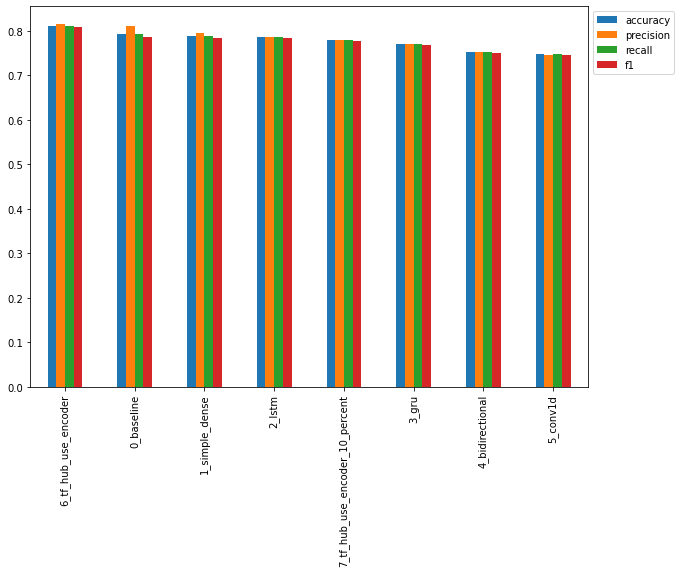

In [ ]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10,7)).legend(bbox_to_anchor=(1.0, 1.0));


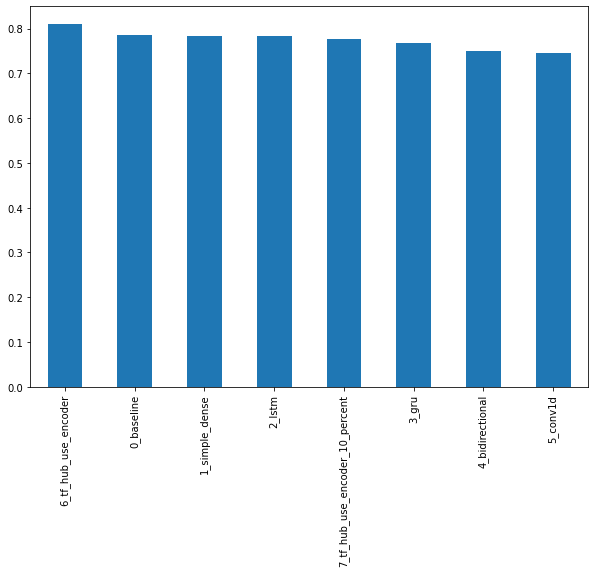

In [ ]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10,7));

## Upload model logs into Tensorboard

In [ ]:
# View TensorBoard logs of transfer learning modelling experiments (plus all of our other models)
!tensorboard dev upload --logdir $SAVE_DIR \
  --name "NLP Deep Learning clasification model experiments"\
  --description "Comparing 6 deep learning binary classification models on Twitter disaster data from Kaggle"\
  --one_shot # exit the uploader once uloading is finished.

2022-08-18 10:12:01.944603: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

model_logs

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3A

If we need to delete an experiment from tensorboard, we can run the following:

1. Run `!tensorboard dev list`
2. copy the id from the experiment

In [ ]:
# See the previous TensorBoard Dev experiments we ran.
!tensorboard dev list

2022-08-18 10:23:03.979625: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
https://tensorboard.dev/experiment/7TaEnaXiQK2BzjoVqKzgcA/
	Name                 NLP Deep Learning clasification model experiments
	Description          Comparing 6 deep learning binary classification models on Twitter disaster data from Kaggle
	Id                   7TaEnaXiQK2BzjoVqKzgcA
	Created              2022-08-18 10:22:50 (28 seconds ago)
	Updated              2022-08-18 10:22:57 (21 seconds ago)
	Runs                 14
	Tags                 5
	Scalars              210
	Tensor bytes         0
	Binary object bytes  2880803
https://tensorboard.dev/experiment/vnjnvKcgT0i6zQYLsvlPUg/
	Name                 NLP Deep Learning clasification model experiments
	Description          Comparing 6 deep learning binary classification models on Twitter disaster data from Kaggle
	Id                   vnjnvKcgT0i6zQYLsvlPUg
	Created   

## Saving and loading a trained model

There are two main formats to save a model to in TensorFlow:
1. The HDF5 format (more compatible outside of TensorFlow)
2. `SavedModel` format (This is the default when using TensorFlow)

In [ ]:
# Save TF Hub Sentence encoder model to HDF5 format
model_6.save("model_6.h5")

Remember in TensorHub there is a lite version of the model, dedicated to devices with lower compute power

In [ ]:
# Load model with custom Hub Layer (required HDF5 format)
loaded_model_6 = tf.keras.models.load_model("model_6.h5",
                                            custom_objects={"KerasLayer":hub.KerasLayer})

In [ ]:
loaded_model_6.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 13ms/step - loss: 0.4325 - accuracy: 0.8110


[0.43245741724967957, 0.8110235929489136]

In [ ]:
model_6_results

{'accuracy': 81.10236220472441,
 'precision': 0.8140341548215564,
 'recall': 0.8110236220472441,
 'f1': 0.809201931950287}

In [ ]:
model_6.save("model_6_SavedModel_format")

In [ ]:
# Load in a model from the SavedModel format
loaded_model_6_SavedModel_format = tf.keras.models.load_model("model_6_SavedModel_format")

In [ ]:
loaded_model_6_SavedModel_format.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 11ms/step - loss: 0.4325 - accuracy: 0.8110


[0.43245741724967957, 0.8110235929489136]

## Finding the most wrong examples

* If our best model still isn't perfect, what examples is it getting wrong?
* And of these wrong examples, which ones is it getting *most* wrong (those prediction probabilities closest to the opposite class)

For example if a sample should have a label of 0 but our model predicts a prediction probability close to 1

In [ ]:
# Download a pretrained model on google api
!wget https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
!unzip 08_model_6_USE_feature_extractor.zip

--2022-08-18 10:23:50--  https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.111.128, 108.177.120.128, 142.251.120.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.111.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 960779165 (916M) [application/zip]
Saving to: ‘08_model_6_USE_feature_extractor.zip’

08_model_6_USE_feat 100%[===================>] 916.27M  40.2MB/s    in 19s     

2022-08-18 10:24:09 (48.6 MB/s) - ‘08_model_6_USE_feature_extractor.zip’ saved [960779165/960779165]

Archive:  08_model_6_USE_feature_extractor.zip
   creating: 08_model_6_USE_feature_extractor/
   creating: 08_model_6_USE_feature_extractor/assets/
   creating: 08_model_6_USE_feature_extractor/variables/
  inflating: 08_model_6_USE_feature_extractor/variables/variables.data-00000-of-00001  
  inflating: 08_model_6_USE_feature_extractor/variables/variabl

In [ ]:
# Import previously trained model from Google Storage
model_6_pretrained = tf.keras.models.load_model("08_model_6_USE_feature_extractor")

In [ ]:
# Make predictions with the loaded model from GS 
model_6_pretrained_pred_probs = model_6_pretrained.predict(val_sentences)
model_6_pretrained_preds = tf.squeeze(tf.round(model_6_pretrained_pred_probs))
model_6_pretrained_preds[:10]

24/24 [==============================] - 1s 11ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

Now we need to create a dataframe with validation sentences, validation labels and best performing model prediction labels and probabilities 

In [ ]:
val_df = pd.DataFrame({"text": val_sentences,
                       "target": val_labels,
                       "pred": model_6_pretrained_preds,
                       "pred_prob": tf.squeeze(model_6_pretrained_pred_probs)})

In [ ]:
val_df

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.159757
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.747162
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.988749
3,@camilacabello97 Internally and externally scr...,1,0.0,0.196229
4,Radiation emergency #preparedness starts with ...,1,1.0,0.707808
...,...,...,...,...
757,That's the ultimate road to destruction,0,0.0,0.137074
758,@SetZorah dad why dont you claim me that mean ...,0,0.0,0.095865
759,FedEx will no longer transport bioterror patho...,0,1.0,0.876982
760,Crack in the path where I wiped out this morni...,0,1.0,0.612631


In [ ]:
# Find the wrong predictions and sort by prediction probabilities 
most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("pred_prob", ascending = False)

In [ ]:
most_wrong.head(10)

,text,target,pred,pred_prob
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.910196
759,FedEx will no longer transport bioterror patho...,0,1.0,0.876982
628,@noah_anyname That's where the concentration c...,0,1.0,0.852300
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.835455
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.827213
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.814816
109,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1.0,0.810840
49,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.803122
119,@freefromwolves GodsLove &amp; #thankU brother...,0,1.0,0.766901
344,Air Group is here to the rescue! We have 24/7 ...,0,1.0,0.766625


Let0s remind ourselves of the target labels...
* `0` = not disaster
* `1` = disaster

In [ ]:
most_wrong.tail(10)

,text,target,pred,pred_prob
536,@DavidVonderhaar At least you were sincere ??,1,0.0,0.067303
408,@willienelson We need help! Horses will die!Pl...,1,0.0,0.055076
294,Lucas Duda is Ghost Rider. Not the Nic Cage ve...,1,0.0,0.054603
221,going to redo my nails and watch behind the sc...,1,0.0,0.054597
59,You can never escape me. Bullets don't harm me...,1,0.0,0.049637
411,@SoonerMagic_ I mean I'm a fan but I don't nee...,1,0.0,0.043918
233,I get to smoke my shit in peace,1,0.0,0.042087
38,Why are you deluged with low self-image? Take ...,1,0.0,0.038998
244,Reddit Will Now QuarantineÛ_ http://t.co/pkUA...,1,0.0,0.038949
23,Ron &amp; Fez - Dave's High School Crush https...,1,0.0,0.037186


In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(val_labels,
                      model_6_preds)

cm

array([[366,  48],
       [ 96, 252]])

In [ ]:
# Check the false positives (mode predicted 1 when should've been ')
for row in most_wrong[:10].itertuples():
  _, text, target, pred, pred_prob = row
  print(f"Target: {target}, Pred: {pred}, Prob: {pred_prob}")
  print(f"Text:\n{text}n\ ")
  print("----\n")

Target: 0, Pred: 1.0, Prob: 0.9101957082748413
Text:
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplayingn\ 
----

Target: 0, Pred: 1.0, Prob: 0.8769820332527161
Text:
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8Jn\ 
----

Target: 0, Pred: 1.0, Prob: 0.8523001670837402
Text:
@noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.n\ 
----

Target: 0, Pred: 1.0, Prob: 0.835454523563385
Text:
Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0n\ 
----

Target: 0, Pred: 1.0, Prob: 0.8272131681442261
Text:
@AshGhebranious civil rights continued in the 60s. And what about trans-generational trauma? if anything we should listen to the Americans.n\ 
----

Target: 0, Pred: 1.0, Prob: 0.8148159384727478
Text:
@SonofLiberty357 all illuminated by the brightly burning buildings all around the t

## Make predictions with the unlabeled test dataframe


In [ ]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [ ]:
test_sentences = test_df.text.to_list()
test_samples = random.sample(test_sentences, 10)

for test_sample in test_samples:
  pred_prob = tf.squeeze(model_6_pretrained.predict([test_sample]))
  pred = tf.round(pred_prob)

  print(f"Pred: {int(pred)}, Prob: {pred_prob}")
  print(f"Text:\n{test_sample}\n")
  print("----\n")



1/1 [==============================] - 0s 40ms/step
Pred: 0, Prob: 0.30904120206832886
Text:
Call for Tasmania's emergency services to be trained in horse rescues http://t.co/zVQwLpScSC

----

1/1 [==============================] - 0s 45ms/step
Pred: 1, Prob: 0.6532546281814575
Text:
The dust storm chase scene is pretty damn cool. #GhostProtocol

----

1/1 [==============================] - 0s 35ms/step
Pred: 1, Prob: 0.7297508120536804
Text:
one of them wild fires in cali or something or in the mid west or where ever they show up..shit dont pop up around me

----

1/1 [==============================] - 0s 33ms/step
Pred: 1, Prob: 0.6534422039985657
Text:
960KZIM: Steele police arrest 2 in possible arson investigation https://t.co/w6ZbWryqjC

----

1/1 [==============================] - 0s 38ms/step
Pred: 1, Prob: 0.6613835096359253
Text:
@21Joseph fire

----

1/1 [==============================] - 0s 33ms/step
Pred: 0, Prob: 0.44623002409935
Text:
Kimanzi_: Breaking news! Unconfirmed!

In [ ]:
test_sentences_pred_probs = model_6_pretrained.predict(test_sentences)
test_sentences_preds = tf.squeeze(tf.round(test_sentences_pred_probs))
test_sentences_preds[:10]

102/102 [==============================] - 1s 11ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 1., 1., 1., 0., 0., 0., 0.], dtype=float32)>

In [ ]:
test_df["pred_probs"] = test_sentences_preds

In [ ]:
test_df.head(10)

,id,keyword,location,text,pred_probs
0,0,NaN,NaN,Just happened a terrible car crash,1.0
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",1.0
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",1.0
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,1.0
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,1.0
5,12,NaN,NaN,We're shaking...It's an earthquake,1.0
6,21,NaN,NaN,They'd probably still show more life than Arse...,0.0
7,22,NaN,NaN,Hey! How are you?,0.0
8,27,NaN,NaN,What a nice hat?,0.0
9,29,NaN,NaN,Fuck off!,0.0


In [ ]:
tweet = "Five months after the floods and the green is coming back. Big garlic harvest coming soon."

pred = tf.squeeze(tf.round(model_6_pretrained.predict([tweet])))
pred

1/1 [==============================] - 0s 48ms/step


<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

## The speed/score tradeoff

Imagine we want to implemnet our best model in Tweeter. Think of how many tweets are performed in an hour and if our model is able to keep up with the speed. The baseline model is much much faster, and maybe those percentual points gained in evaluation metrics is good to have. However we also need to take into account the speed of the model. This is what we will do now. We will write a function that evaluates on this

In [ ]:
model_6_results

{'accuracy': 81.10236220472441,
 'precision': 0.8140341548215564,
 'recall': 0.8110236220472441,
 'f1': 0.809201931950287}

In [ ]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [ ]:
# Let's make a function to measure the time of predictio
import time
def pred_timer(model, samples):
  """
  Times how long a model takes to make predictions on samples.
  """
  start_time = time.perf_counter() # get start time
  model.predict(samples)
  end_time = time.perf_counter()
  total_time = end_time-start_time
  time_per_pred = total_time/len(samples)
  return total_time, time_per_pred

In [ ]:
# Calculate TF Hub Sentence Encoder time per pred
model_6_total_pred_time, model_6_time_per_pred = pred_timer(model_6_pretrained,
                                                            samples=val_sentences)
model_6_total_pred_time, model_6_time_per_pred

24/24 [==============================] - 0s 11ms/step


(0.3569571250000081, 0.00046844767060368514)

In [ ]:
# Calculate our baseline model times per pred
baseline_total_pred_time, baseline_time_per_pred = pred_timer(model_0, val_sentences)
baseline_total_pred_time, baseline_time_per_pred

(0.035463232999973116, 4.653967585298309e-05)

In [ ]:
model_6_pretrained_results = calculate_results(y_true=val_labels,
                                               y_pred=model_6_pretrained_preds)

model_6_pretrained_results

{'accuracy': 81.62729658792651,
 'precision': 0.818446310697231,
 'recall': 0.8162729658792651,
 'f1': 0.8148082644367335}

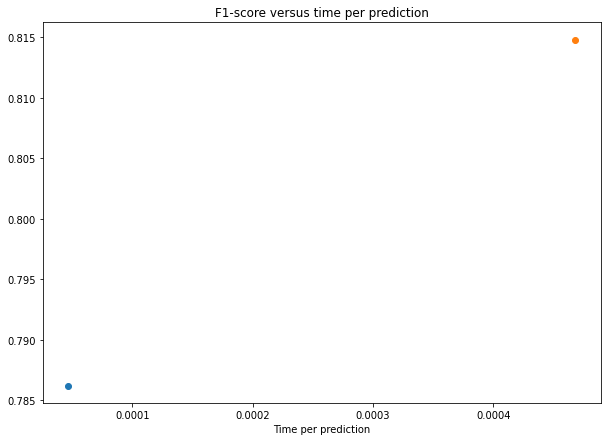

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,7));
plt.scatter(baseline_time_per_pred, baseline_results["f1"], label="baseline")
plt.scatter(model_6_time_per_pred, model_6_pretrained_results["f1"], label="tfhub_sentence_encoder")
plt.title("F1-score versus time per prediction");
plt.xlabel("Time per prediction");

### Task, find the majority score (mode) of all model predictions.

First we want to show them nicely in a dataframe, then calculate the mode and see if majority score improves the metrics

In [ ]:
models_preds_df = pd.DataFrame({"baseline_preds": baseline_preds,
                                "model_1_preds": model_1_preds,
                                "model_2_preds": model_2_preds,
                                "model_3_preds": model_3_preds,
                                "model_4_preds": model_4_preds,
                                "model_5_preds": model_5_preds,
                                "model_6_preds": model_6_preds,
                                })

In [ ]:
mode_df = models_preds_df.mode(axis=1)
mode_df.columns = ["pred_modes"]
mode_df["val_labels"] = val_labels

In [ ]:
mode_df.head()

,pred_modes,val_labels
0,0.0,0
1,1.0,0
2,1.0,1
3,0.0,1
4,0.0,1


In [ ]:
ensemble_preds = mode_df.pred_modes.values

ensemble_score = calculate_results(ensemble_preds,
                                   val_labels)

In [ ]:
ensemble_score

{'accuracy': 78.34645669291339,
 'precision': 0.7913319696232374,
 'recall': 0.7834645669291339,
 'f1': 0.7851334869739022}

In [ ]:
model_6_results

{'accuracy': 81.10236220472441,
 'precision': 0.8140341548215564,
 'recall': 0.8110236220472441,
 'f1': 0.809201931950287}